In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from chromalab.spectra import Spectra
from chromalab.observer import Observer, Cone, neitz_cone
from chromalab.inks import Neugebauer, InkGamut

In [4]:
wavelengths1 = np.arange(390, 701, 1)
wavelengths10 = np.arange(400, 701, 10)

In [5]:
def BaylorNomogram(wls, lambdaMax: int):
    """
    Compute spectral sensitivities according to the
    nomogram provided in Baylor, Nunn, and Schnapf, 1987.

    The result is in quantal units, in the sense that to compute
    absorptions you want to input incident spectra in quanta.
    To get sensitivity in energy units, apply EnergyToQuanta().

    Argument lambdaMax may be a column vector of wavelengths.
    """
    # These are the coefficients for the polynomial approximation.
    aN = np.array([-5.2734, -87.403, 1228.4, -3346.3, -5070.3, 30881, -31607])

    # Assuming MakeItWls(S) is a function to generate wavelengths based on input S.
    # You need to define or replace MakeItWls(S) with appropriate Python code.
    # For the purpose of this translation, let's assume S is already a list/array of wavelengths.
    nWls = len(wls)
    
    wlsum = wls / 1000.0
    wlsVec = np.log10((1.0 / wlsum) * lambdaMax / 561)
    logS = aN[0] + aN[1]*wlsVec + aN[2]*wlsVec**2 + aN[3]*wlsVec**3 + \
               aN[4]*wlsVec**4 + aN[5]*wlsVec**5 + aN[6]*wlsVec**6
    T = 10 ** logS
    return T.T

In [43]:
def plot(wavelengths, data, ax=None, f=None, color=None, label=None):
    if f is None:
        f = lambda x: x
    if ax is None:
        ax = plt
    ax.plot(wavelengths, f(data), color=color, label=label)

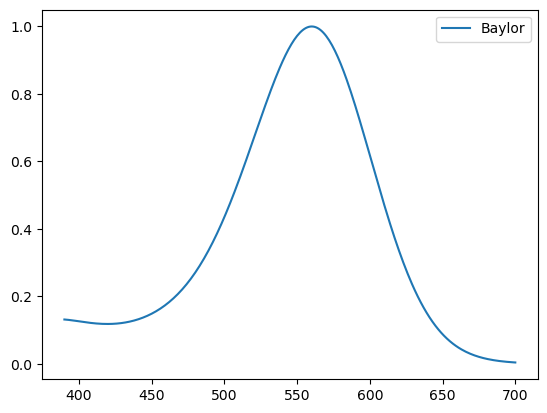

In [79]:
plot(wavelengths1, BaylorNomogram(wavelengths1, 560), label="Baylor")

In [35]:
def GovardovskiiNomogram(S, lambdaMax):
    """
    Compute normalized absorbance according to the
    nomogram provided in Victor I. Govardovskii et al., 2000,
    Visual Neuroscience, Vol. 17, pp. 509-528.
    """
    # Valid range of wavelength for A1-based visual pigments
    Lmin, Lmax = 330, 700

    # Valid range of lambdaMax value
    lmaxLow, lmaxHigh = 350, 600

    # Alpha-band parameters
    A, B, C = 69.7, 28, -14.9
    D = 0.674
    b, c = 0.922, 1.104

    # Beta-band parameters
    Abeta = 0.26

    # Assuming S is directly the wavelengths array
    wls = np.array(S)

    nWls = len(wls)
    T_absorbance = np.zeros((1, nWls))  # nT is assumed to be 1 based on user note

    if lmaxLow < lambdaMax < lmaxHigh:
        # alpha-band polynomial
        a = 0.8795 + 0.0459 * np.exp(-(lambdaMax - 300) ** 2 / 11940)
        
        x = lambdaMax / wls
        midStep1 = np.exp(np.array([A, B, C]) * np.array([a, b, c]) - x[:, None] * np.array([A, B, C]))
        midStep2 = np.sum(midStep1, axis=1) + D
        
        S_x = 1 / midStep2
        
        # Beta-band polynomial
        bbeta = -40.5 + 0.195 * lambdaMax
        lambdaMaxbeta = 189 + 0.315 * lambdaMax
        
        midStep1 = -((wls - lambdaMaxbeta) / bbeta) ** 2
        S_beta = Abeta * np.exp(midStep1)
        
        # alpha band and beta band together
        T_absorbance[0, :] = S_x + S_beta
        
        # Zero sensitivity outside valid range
        T_absorbance[0, wls < Lmin] = 0
        T_absorbance[0, wls > Lmax] = 0
    else:
        raise ValueError(f'Lambda Max {lambdaMax} not in range of nomogram')

    return T_absorbance.T


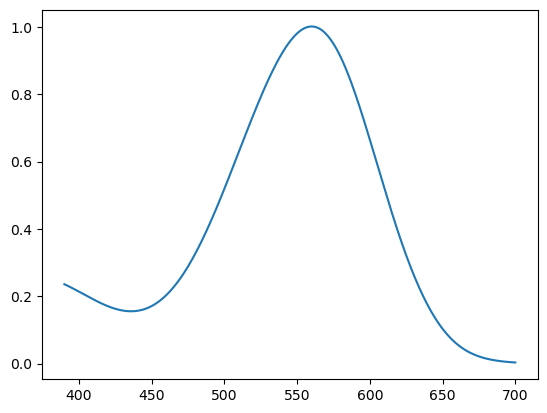

In [32]:
plot(wavelengths1, GovardovskiiNomogram(wavelengths1, 560))

In [36]:
def LambNomogram(S, lambdaMax):
    """
    Compute spectral sensitivities according to the
    nomogram provided in Lamb, 1995, Vision Research,
    Vol. 35, pp. 3083-3091, equation 2'.
    """
    # Coefficients for Equation 2
    a, b, c = 70, 28.5, -14.1
    A, B, C, D = 0.880, 0.924, 1.104, 0.655

    # Assuming S is directly the wavelengths array
    wls = np.array(S)

    T = np.zeros(len(wls))  # Since nT is assumed to be 1 based on user note

    wlarg = lambdaMax / wls
    T = 1 / (np.exp(a * (A - wlarg)) + np.exp(b * (B - wlarg)) +
             np.exp(c * (C - wlarg)) + D)
    T = T / max(T)  # Normalize the sensitivity to peak at 1

    return T

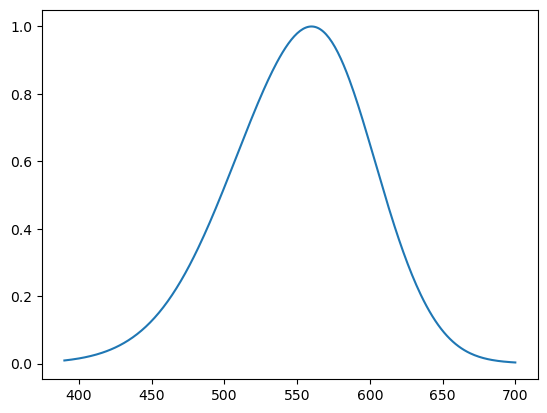

In [37]:
plot(wavelengths1, LambNomogram(wavelengths1, 560))

In [38]:
def StockmanSharpeNomogram(S, lambdaMax):
    """
    Compute normalized absorbance according to the
    nomogram provided by Stockman and Sharpe.
    """
    # Polynomial coefficients
    a = -188862.970810906644
    b = 90228.966712600282
    c = -2483.531554344362
    d = -6675.007923501414
    e = 1813.525992411163
    f = -215.177888526334
    g = 12.487558618387
    h = -0.289541500599

    # Assuming S is directly the wavelengths array
    wls = np.array(S)

    # Prepare the wavelengths normalization
    logWlsNorm = np.log10(wls) - np.log10(lambdaMax / 558)

    # Compute log optical density
    logDensity = (a + b * logWlsNorm**2 + c * logWlsNorm**4 + 
                  d * logWlsNorm**6 + e * logWlsNorm**8 + 
                  f * logWlsNorm**10 + g * logWlsNorm**12 + 
                  h * logWlsNorm**14)

    # Convert log10 absorbance to absorbance
    T_absorbance = 10**logDensity

    return T_absorbance


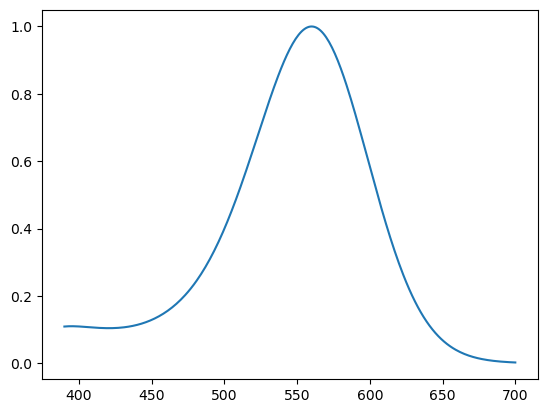

In [39]:
plot(wavelengths1, StockmanSharpeNomogram(wavelengths1, 560))

In [49]:
def NeitzNomogram(wavelengths, lambda_max=559):
    # From Neitz website
    # From Carroll, McMahon, Neitz, & Neitz (2000)
    # based on Partridge and DeGrip '91 bovine data
    
    wavelengths = wavelengths.astype(np.float32)

    A = 0.417050601
    B = 0.002072146
    C = 0.000163888
    D = -1.922880605
    E = -16.05774461
    F = 0.001575426
    G = 5.11376e-05
    H = 0.00157981
    I = 6.58428e-05
    J = 6.68402e-05
    K = 0.002310442
    L = 7.31313e-05
    M = 1.86269e-05
    N = 0.002008124
    O = 5.40717e-05
    P = 5.14736e-06
    Q = 0.001455413
    R = 4.217640000e-05
    S = 4.800000000e-06
    T = 0.001809022
    U = 3.86677000e-05
    V = 2.99000000e-05
    W = 0.001757315
    X = 1.47344000e-05
    Y = 1.51000000e-05

    A2 = (np.log10(1.00000000 / lambda_max) - np.log10(1.00000000 / 558.5))
    vector = np.log10(np.reciprocal(wavelengths))
    const = 1 / np.sqrt(2 * np.pi)

    ex_temp1 = np.log10(-E + E * np.tanh(-((10 ** (vector - A2)) - F) / G)) + D
    ex_temp2 = A * np.tanh(-(((10 ** (vector - A2))) - B) / C)
    ex_temp3 = -(J / I * (const * np.exp(-0.5 * (((10 ** (vector - A2)) - H) / I) ** 2)))
    ex_temp4 = -(M / L * (const * np.exp(-0.5 * (((10 ** (vector - A2)) - K) / L) ** 2)))
    ex_temp5 = -(P / O * (const * np.exp(-0.5 * (((10 ** (vector - A2)) - N) / O) ** 2)))
    ex_temp6 = (S / R * (const * np.exp(-0.5 * (((10 ** (vector - A2)) - Q) / R) ** 2)))
    ex_temp7 = ((V / U * (const * np.exp(-0.5 * (((10 ** (vector - A2)) - T) / U) ** 2))) / 10)
    ex_temp8 = ((Y / X * (const * np.exp(-0.5 * (((10 ** (vector - A2)) - W) / X) ** 2))) / 100)
    ex_temp = ex_temp1 + ex_temp2 + ex_temp3 + ex_temp4 + ex_temp5 + ex_temp6 + ex_temp7 + ex_temp8

    return 10 ** ex_temp

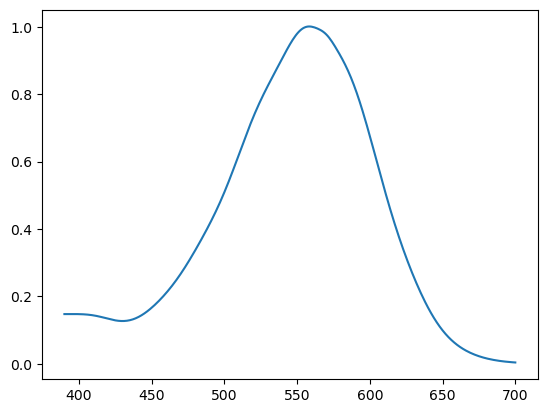

In [50]:
plot(wavelengths1, NeitzNomogram(wavelengths1, 560))

In [52]:
stockman_fourier_data = """
a0	−42.417609	−2.125656
a1	−2.656792	5.467793
b1	75.011094	0.896066
a2	56.477063	−0.953011
b2	7.509398	−5.037710
a3	9.061442	−3.003999
b3	−38.068488	−0.950862
a4	−20.974610	−1.367085
b4	−6.642746	1.770211
a5	−3.785039	0.516505
b5	9.322071	1.150550
a6	3.134495	0.610042
b6	1.603799	0.051821
a7	0.439302	0.100928
b7	−0.676959	−0.177357
a8	−0.072988	−0.027880
b8	−0.078858	−0.042774
s	−0.004264	0.000705
"""

In [73]:
a_coefs = []
b_coefs = []

for row in stockman_fourier_data.split("\n"):
    vals = row.split("\t")
    if not vals[0]: continue
    print(vals)
    num = float(vals[1].replace('−', '-'))
    if vals[0].startswith('a'):
        a_coefs.append(num)
    elif vals[0].startswith('b'):
        b_coefs.append(num)

['a0', '−42.417609', '−2.125656']
['a1', '−2.656792', '5.467793']
['b1', '75.011094', '0.896066']
['a2', '56.477063', '−0.953011']
['b2', '7.509398', '−5.037710']
['a3', '9.061442', '−3.003999']
['b3', '−38.068488', '−0.950862']
['a4', '−20.974610', '−1.367085']
['b4', '−6.642746', '1.770211']
['a5', '−3.785039', '0.516505']
['b5', '9.322071', '1.150550']
['a6', '3.134495', '0.610042']
['b6', '1.603799', '0.051821']
['a7', '0.439302', '0.100928']
['b7', '−0.676959', '−0.177357']
['a8', '−0.072988', '−0.027880']
['b8', '−0.078858', '−0.042774']
['s', '−0.004264', '0.000705']


In [77]:
print(b_coefs)

[75.011094, 7.509398, -38.068488, -6.642746, 9.322071, 1.603799, -0.676959, -0.078858]


In [62]:
def fourier_polynomial(x, a0, a, b, d=1):
    """
    Compute the value of a Fourier polynomial.
    
    Parameters:
    - x: input value(s) for the polynomial (scalar or numpy array)
    - coefficients: a dictionary with keys 'a' and 'b' for the coefficients of cosine and sine terms, respectively,
                    and 'a0' for the constant term. Each should be a list or numpy array where the nth element
                    corresponds to the coefficient for the nth term.
    - d: a scalar multiplier for the whole polynomial (default is 1)
    
    Returns:
    - The value of the Fourier polynomial at x.
    """
    
    k = np.arange(1, len(a) + 1)
    cos_terms = a * np.cos(k * x)
    sin_terms = b * np.sin(k * x)
    
    return d * (a0 + np.sum(cos_terms + sin_terms))

In [ ]:
def StockmanRiderNomogramL(wavelengths, lambda_max):
    # From Formulae for generating standard and individual human cone spectral sensitivities
    # Stockman & Rider (2023)
    a0 = -42.417609
    a =  [-2.656792, 56.477063, 9.061442, -20.97461, -3.785039, 3.134495, 0.439302, -0.072988]
    b = [75.011094, 7.509398, -38.068488, -6.642746, 9.322071, 1.603799, -0.676959, -0.078858]
    d = 0.004264
    return fourier_polynomial(wavelengths)

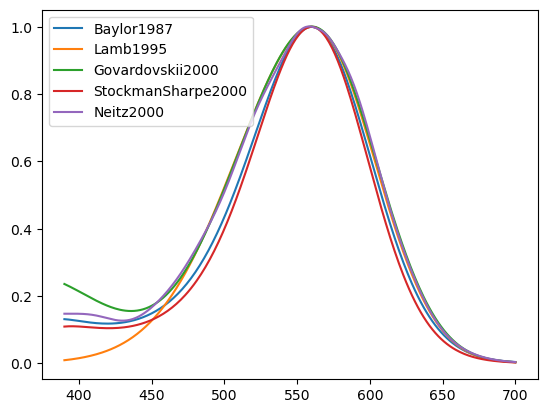

In [85]:
plot(wavelengths1, BaylorNomogram(wavelengths1, 560), label="Baylor1987")
plot(wavelengths1, LambNomogram(wavelengths1, 560), label="Lamb1995")
plot(wavelengths1, GovardovskiiNomogram(wavelengths1, 560), label="Govardovskii2000")
plot(wavelengths1, StockmanSharpeNomogram(wavelengths1, 560), label="StockmanSharpe2000")
plot(wavelengths1, NeitzNomogram(wavelengths1, 560), label="Neitz2000")
plt.legend()

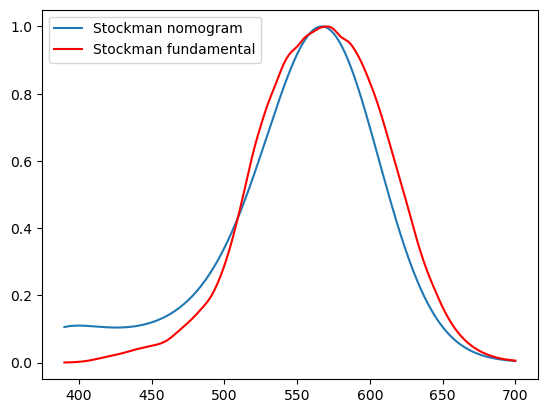

In [95]:
plot(wavelengths1, StockmanSharpeNomogram(wavelengths1, 567), label="Stockman nomogram")
Cone.l_cone().plot(name="Stockman fundamental", color='red')
plt.legend()